In [1]:
import numpy as np
import torch
import qtorch
from qtorch.quant import posit_quantize


Using /home/minh/torch_extension as PyTorch extensions root...
Emitting ninja build file /home/minh/torch_extension/quant_cpu/build.ninja...
Building extension module quant_cpu...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module quant_cpu...
Using /home/minh/torch_extension as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/minh/torch_extension/quant_cuda/build.ninja...
Building extension module quant_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module quant_cuda...


In [2]:
a = np.arange(-20,20,2.5)
a = torch.tensor(a, dtype=torch.float)
#a = torch.rand(10)
b = posit_quantize(a,nsize=4,es=1)

print (a) 
print (b)


tensor([-20.0000, -17.5000, -15.0000, -12.5000, -10.0000,  -7.5000,  -5.0000,
         -2.5000,   0.0000,   2.5000,   5.0000,   7.5000,  10.0000,  12.5000,
         15.0000,  17.5000])
tensor([-16., -16., -16., -16., -16.,  -4.,  -4.,  -2.,   0.,   2.,   4.,   4.,
         16.,  16.,  16.,  16.])


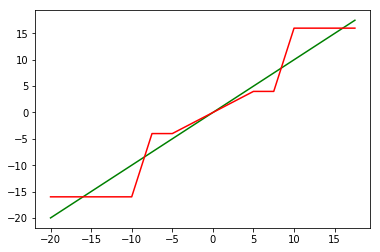

In [3]:
import matplotlib.pyplot as plt
plt.plot (a,a, color="green")
plt.plot (a,b, color="red")

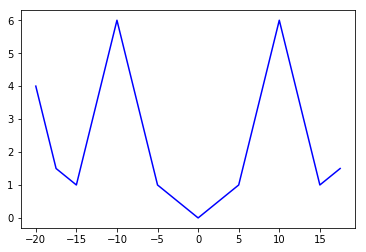

In [4]:
plt.plot (a,np.abs(a-b), color="blue")

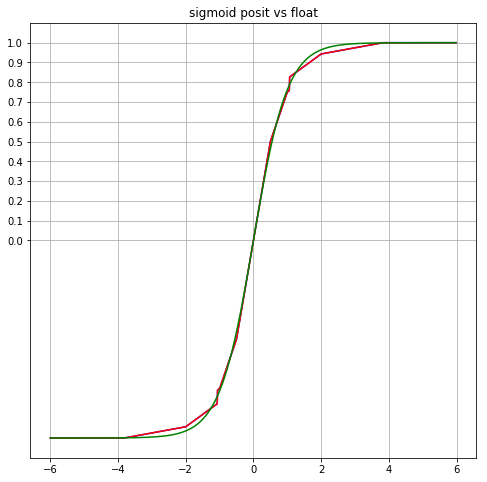

In [5]:
#test sigmoid
import numpy as np
import matplotlib.pyplot as plt
from qtorch.quant import posit_quantize, posit_sigmoid, posit_tanh, posit_tanh_enhanced
plt.rcParams["figure.figsize"]=8,8
import torch

def sigmoid(x) : 
    return np.exp(x)/(np.exp(x)+1)

from qtorch.quant import posit_sigmoid
input = np.arange(-6,6,0.01)
input_tensor = torch.tensor(input, dtype=torch.float)
input_tensor_gpu = torch.tensor(input, dtype=torch.float).cuda()

out_16_gpu = posit_tanh_enhanced(input_tensor_gpu,nsize=16,es=0)
out_16 = posit_tanh_enhanced(input_tensor,nsize=16,es=0)
plt.plot(input, out_16.numpy().flatten(),color='blue')
plt.plot(input, out_16_gpu.cpu().numpy().flatten(),color='red')
plt.plot(input,np.tanh(input),color='green')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.title('sigmoid posit vs float')
plt.show()


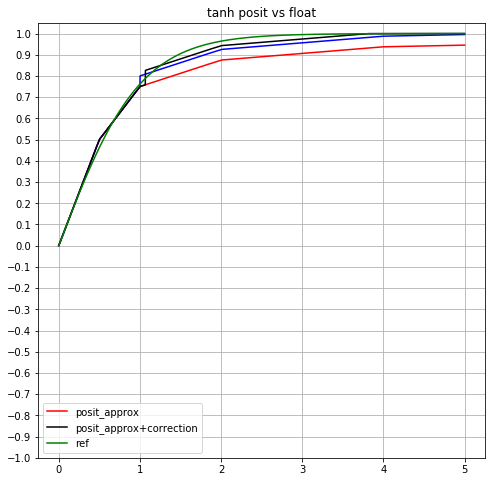

In [6]:

input = np.arange(0,5,0.001)
input_tensor = torch.tensor(input, dtype=torch.float)
def tanh(x) : 
    return np.exp(x)/(np.exp(x)+1)
def correction(element):
    if (element>0.75):
        return min(element+0.05, 1)
    elif (element<-0.75):
        return max(element-0.05, -1)
    else : 
        return element

out_8 = posit_tanh(input_tensor,nsize=8,es=0)
out_16 = posit_tanh(input_tensor,nsize=16,es=0)
corrected_tanh = np.fromiter(map(correction, out_16.numpy().flatten()), dtype=float)

out_16_enhanced = posit_tanh_enhanced(input_tensor,nsize=16,es=0)

plt.plot(input, out_16.numpy().flatten(),color='red',label = "posit_approx")
plt.plot(input, corrected_tanh,color='blue')
#plt.plot(input, out_8.numpy().flatten() * 1.05,color='blue')
plt.plot(input, out_16_enhanced,color='black', label = "posit_approx+correction")
plt.plot(input,np.tanh(input),color='green', label="ref")
plt.title('tanh posit vs float')
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.grid()
plt.legend()
plt.show()

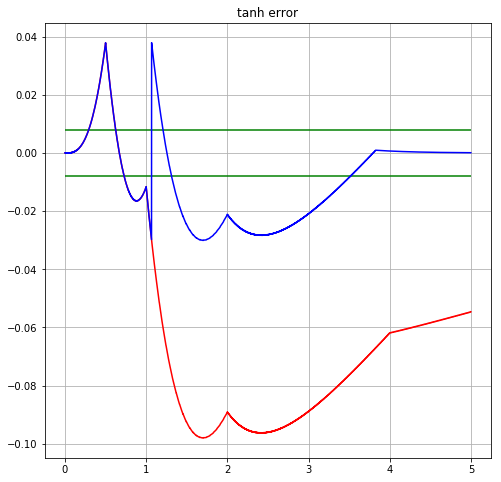

max_err  0.03788284273999026  minerr  -0.09801449493546077
mid point  0.06794866883772552 midpoint from 0  -0.030065826097735254
index nearest  1067
mid point input  1.067  output  0.7583008  errr  -0.03002750694250611


In [7]:
plt.plot(input, out_16.numpy().flatten() - np.tanh(input),color='red')
plt.plot(input, out_16_enhanced.numpy().flatten() - np.tanh(input),color='blue')
plt.hlines([-2/255.0, 2/255.0], min(input), max(input),color = 'green')
plt.title('tanh error')
plt.grid()
plt.show()
output = out_16.cpu().detach().numpy().flatten()
error = out_16.numpy().flatten() - np.tanh(input)
max_index = np.argmax(error)
min_index = np.argmin(error)
mid_point = abs(error[max_index] + abs( error[min_index]))/2
print ('max_err ', error[max_index], ' minerr ', error[min_index])
print ('mid point ', mid_point, 'midpoint from 0 ', mid_point + error[min_index])
mid_point_corrected = mid_point + error[min_index]
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import math
print('index nearest ', find_nearest(error, mid_point_corrected))
index_err = find_nearest(error, mid_point_corrected)
print ('mid point input ', input[index_err], ' output ', output[index_err], ' errr ', error[index_err])

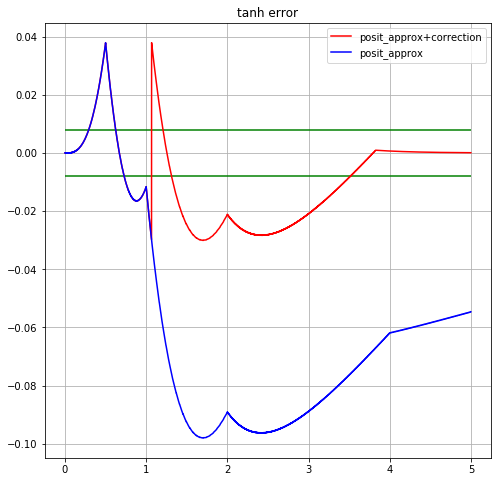

In [8]:
def correction(element):
    if (element>0.6):
        return min(element*1.07, 1)
    elif (element<-0.6):
        return max(element*1.07, -1)
    else : 
        return element
def correction2(element):
    if (element>0.7583):
        return min(element+0.06795, 1)
    elif (element<-0.7583):
        return max(element-0.06795,-1)
    else : 
        return element

corrected_tanh = np.fromiter(map(correction2, out_16.numpy().flatten()), dtype=float)
plt.plot(input, corrected_tanh - np.tanh(input) ,color='red',label = "posit_approx+correction")
plt.plot(input, out_16.numpy().flatten() - np.tanh(input),color='blue',label = "posit_approx")
#plt.scatter(input, corrected_tanh - np.tanh(input) ,marker = 'x',facecolors='none', edgecolors='r',color='red',label = "posit_approx+correction")
#plt.scatter(input, out_16.numpy().flatten() - np.tanh(input), marker='o',facecolors='none', edgecolors='b',color='blue',label = "posit_approx")

plt.hlines([-2/255.0, 2/255.0], min(input), max(input),color = 'green')
plt.title('tanh error')
plt.legend()
plt.grid()
plt.show()

tensor([0.0000, 0.0010, 0.0020,  ..., 0.9452, 0.9452, 0.9453])


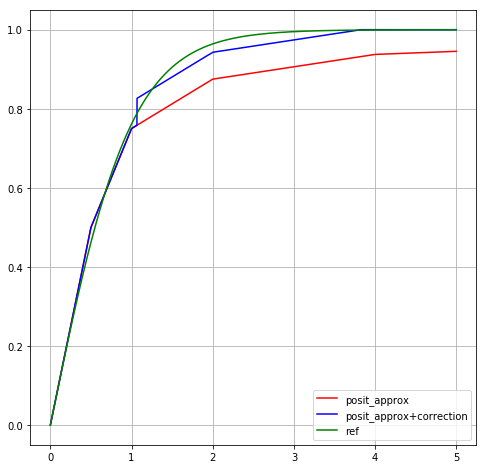

In [9]:
import torch.nn as nn
import torch
from qtorch.quant import posit_quantize, posit_sigmoid, posit_tanh, posit_tanh_enhanced
from qtorch import PositTanhModule, PositTanhModuleEnhanced

posit_tanh_module = PositTanhModule()
posit_tanh_module_enhanced = PositTanhModuleEnhanced()
out_pytorch = posit_tanh_module(input_tensor)
out_pytorch_enhanced = posit_tanh_module_enhanced(input_tensor)
print (out_pytorch)
plt.plot(input, out_pytorch ,color='red',label = "posit_approx")
plt.plot(input, out_pytorch_enhanced ,color='blue',label = "posit_approx+correction")

plt.plot(input, np.tanh(input) ,color='green',label = "ref")
plt.legend()
plt.grid()

plt.show()

2000
2000


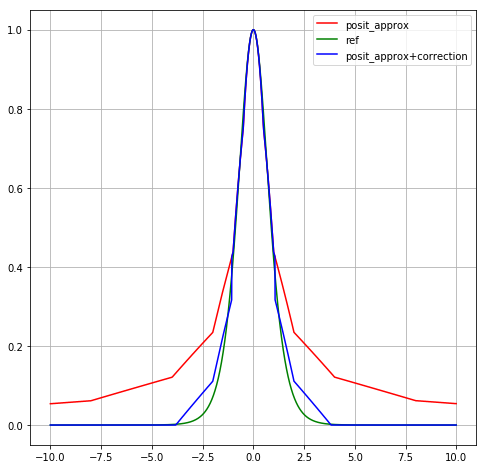

In [10]:
from torch.autograd import gradcheck
input_np = np.arange(-10,10,0.01)
from qtorch import RefTanhModule
input = (torch.tensor(input_np,dtype=torch.float,requires_grad=True))
output = posit_tanh_module(input)
c = output.mean()
c.backward(torch.tensor(float(len(input_np))))
print (len(input.grad))
plt.plot (input_np, input.grad, color = "red",label = "posit_approx")
input_ref = (torch.tensor(input_np,dtype=torch.float,requires_grad=True))
ref_tanh = RefTanhModule()
output_ref = ref_tanh(input_ref)
c_ref = output_ref.mean()
c_ref.backward(torch.tensor(float(len(input_np))))
plt.plot(input_np, input_ref.grad, color='green',label = "ref")

input_enhanced = (torch.tensor(input_np,dtype=torch.float,requires_grad=True))
output_enhanced = posit_tanh_module_enhanced(input_enhanced)
c_enhanced = output_enhanced.mean()
c_enhanced.backward(torch.tensor(float(len(input_np))))
print (len(input.grad))
plt.plot (input_np, input_enhanced.grad, color = "blue",label = "posit_approx+correction")
plt.legend()
plt.grid()
plt.show()
